In [1]:
pip install scikit-surprise


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
print("Loading models and data...")

# Load collaborative filtering model
with open("./Pickle/book_cf_model.pkl", "rb") as f:
    cf_model = pickle.load(f)

# Load content-based cosine similarity
with open("./Pickle/book_content_cosine_sim_matrix.pkl", "rb") as f:
    content_sim_matrix = pickle.load(f)

# Load book indices
with open("./Pickle/book_content_indices.pkl", "rb") as f:
    title_to_indices = pickle.load(f)

# Load book_id mappings
with open("./Pickle/book_id_mappings.pkl", "rb") as f:
    mappings = pickle.load(f)
    bookid_to_index = mappings['bookid_to_index']
    index_to_bookid = mappings['index_to_bookid']

# Load data
ratings_df = pd.read_csv("ratings.csv")
books_df = pd.read_csv("books.csv")

print("✅ Models loaded successfully!")
print(f"   Books: {len(books_df):,}")
print(f"   Ratings: {len(ratings_df):,}")
print(f"   Content similarity matrix: {content_sim_matrix.shape}")


Loading models and data...
✅ Models loaded successfully!
   Books: 10,000
   Ratings: 981,756
   Content similarity matrix: (10000, 10000)


In [4]:
def hybrid_recommend_book(user_id, book_title, alpha=0.5, num_recommendations=10):
    """
    Generate hybrid book recommendations using Content-Based + Collaborative Filtering.
    
    Args:
        user_id: User ID
        book_title: Title of the book (seed)
        alpha: Weight for content-based (0-1). 1=pure content, 0=pure collaborative
        num_recommendations: Number of recommendations to return
    
    Returns:
        DataFrame with recommended books and scores
    """
    
    # Normalize book title
    book_title_norm = book_title.lower().strip()
    book_row = books_df[books_df['title'].str.lower().str.strip() == book_title_norm]
    
    if book_row.empty:
        print(f"❌ Book '{book_title}' not found in dataset.")
        return pd.DataFrame(columns=[
            'book_id', 'title', 'authors', 'hybrid_score',
            'content_score', 'collab_score', 'content_pct', 'collab_pct'
        ])
    
    book_id = book_row['book_id'].values[0]
    book_idx_in_content = bookid_to_index.get(book_id)
    
    if book_idx_in_content is None:
        print(f"❌ Book '{book_title}' not found in content-based model.")
        return pd.DataFrame(columns=[
            'book_id', 'title', 'authors', 'hybrid_score',
            'content_score', 'collab_score', 'content_pct', 'collab_pct'
        ])
    
    # --- Content-based similarities ---
    book_similarities = content_sim_matrix[book_idx_in_content]
    content_min, content_max = book_similarities.min(), book_similarities.max()
    content_norm = (book_similarities - content_min) / (content_max - content_min + 1e-8)
    similar_indices = content_norm.argsort()[::-1]
    
    # --- Helper: CF score lookup ---
    def get_cf_score(user_id, book_id):
        try:
            pred = cf_model.predict(user_id, book_id)
            # Scale from 1-5 to 0-1
            return (pred.est - 1) / 4.0
        except:
            return 0.0
    
    # Collect top-N similar books
    valid_indices = []
    for idx in similar_indices:
        rec_book_id = books_df.iloc[idx]['book_id']
        if rec_book_id != book_id:  # skip seed
            valid_indices.append(idx)
        if len(valid_indices) >= num_recommendations:
            break
    
    # Build results
    results = []
    for idx in valid_indices:
        rec_book_id = books_df.iloc[idx]['book_id']
        rec_title = books_df.iloc[idx]['title']
        rec_authors = books_df.iloc[idx]['authors']
        
        content_score = float(content_norm[idx])
        collab_score = get_cf_score(user_id, rec_book_id)
        
        hybrid_score = alpha * content_score + (1 - alpha) * collab_score
        content_pct = alpha * content_score / hybrid_score * 100 if hybrid_score > 0 else 0
        collab_pct = (1 - alpha) * collab_score / hybrid_score * 100 if hybrid_score > 0 else 0
        
        results.append({
            'book_id': rec_book_id,
            'title': rec_title,
            'authors': rec_authors,
            'hybrid_score': hybrid_score,
            'content_score': content_score,
            'collab_score': collab_score,
            'content_pct': content_pct,
            'collab_pct': collab_pct
        })
    
    return pd.DataFrame(results).sort_values(by='hybrid_score', ascending=False).head(num_recommendations)


In [5]:
print("\n" + "="*70)
print("TESTING HYBRID RECOMMENDATION")
print("="*70)

# Sample a user and book
sample_user = ratings_df['user_id'].sample(1, random_state=42).values[0]
sample_book = books_df['title'].sample(1, random_state=42).values[0]

print(f"\nSample User ID: {sample_user}")
print(f"Sample Book: {sample_book}")

recommendations = hybrid_recommend_book(
    user_id=sample_user, 
    book_title=sample_book, 
    alpha=0.5, 
    num_recommendations=5
)

print(f"\n🎯 Top 5 Hybrid Recommendations:")
if not recommendations.empty:
    for idx, row in recommendations.iterrows():
        print(f"\n{idx+1}. {row['title']}")
        print(f"   by {row['authors']}")
        print(f"   Hybrid Score: {row['hybrid_score']:.4f}")
        print(f"   Content: {row['content_pct']:.1f}% | Collab: {row['collab_pct']:.1f}%")



TESTING HYBRID RECOMMENDATION

Sample User ID: 19643
Sample Book: Scion of Ikshvaku (RamChandra, #1)

🎯 Top 5 Hybrid Recommendations:

1. The Secret of the Nagas (Shiva Trilogy #2)
   by Amish Tripathi
   Hybrid Score: 0.9022
   Content: 47.1% | Collab: 52.9%

2. The Immortals of Meluha (Shiva Trilogy, #1)
   by Amish Tripathi
   Hybrid Score: 0.8969
   Content: 46.8% | Collab: 53.2%

3. The Oath of the Vayuputras (Shiva Trilogy, #3)
   by Amish Tripathi
   Hybrid Score: 0.8954
   Content: 46.7% | Collab: 53.3%

4. Chanakya's Chant
   by Ashwin Sanghi
   Hybrid Score: 0.8433
   Content: 43.4% | Collab: 56.6%

5. The Krishna Key
   by Ashwin Sanghi
   Hybrid Score: 0.8386
   Content: 43.1% | Collab: 56.9%


In [6]:
def evaluate_hybrid_books(test_users, model_function, alpha=0.5, 
                          k_values=[5, 10, 15, 20], similarity_threshold=0.15):  # FIXED: 0.5 → 0.15
    """
    Similarity-based Precision@K and Recall@K for hybrid recommender.
    FIXED: Lower similarity threshold based on data distribution.
    """
    precision_scores = {k: [] for k in k_values}
    recall_scores = {k: [] for k in k_values}
    
    evaluated_count = 0
    
    for user_id in test_users:
        # Books the user liked (rating >= 4)
        user_true_books = set(
            ratings_df[(ratings_df['user_id'] == user_id) & 
                      (ratings_df['rating'] >= 4)]['book_id']
        )
        
        if len(user_true_books) < 2:
            continue
        
        # Use each liked book as seed
        for seed_book_id in list(user_true_books)[:5]:  # Test with up to 5 seeds per user
            # Get book title
            seed_title_rows = books_df.loc[books_df['book_id'] == seed_book_id, 'title'].values
            if len(seed_title_rows) == 0:
                continue
            seed_title = seed_title_rows[0]
            
            for k in k_values:
                recommended_df = model_function(
                    user_id=user_id,
                    book_title=seed_title,
                    alpha=alpha,
                    num_recommendations=k
                )
                
                if recommended_df.empty:
                    continue
                
                recommended_list = recommended_df['book_id'].tolist()
                evaluated_count += 1
                
                # Similarity-based relevance
                relevant_count = 0
                for rec_book_id in recommended_list:
                    for true_book_id in user_true_books:
                        if rec_book_id == true_book_id:
                            continue
                        
                        idx_rec = bookid_to_index.get(rec_book_id)
                        idx_true = bookid_to_index.get(true_book_id)
                        
                        if idx_rec is None or idx_true is None:
                            continue
                        
                        sim_score = content_sim_matrix[idx_rec, idx_true]
                        if sim_score >= similarity_threshold:  # FIXED: Now uses 0.15
                            relevant_count += 1
                            break
                
                precision = relevant_count / len(recommended_list) if recommended_list else 0
                recall = relevant_count / min(k, len(user_true_books) - 1) if len(user_true_books) > 1 else 0
                
                precision_scores[k].append(precision)
                recall_scores[k].append(recall)
    
    # Average
    avg_precision = {k: np.mean(precision_scores[k]) if precision_scores[k] else 0 for k in k_values}
    avg_recall = {k: np.mean(recall_scores[k]) if recall_scores[k] else 0 for k in k_values}
    
    print(f"\n📊 Evaluation Statistics:")
    print(f"  Total evaluations: {evaluated_count}")
    print(f"  Similarity threshold: {similarity_threshold}")
    
    return avg_precision, avg_recall


In [7]:
def evaluate_hybrid_rmse_books(test_users, alpha=0.5, num_predictions=10):
    """
    Evaluate hybrid recommender using RMSE and MAE.
    FIXED: Clips predictions to valid range.
    """
    actual_ratings = []
    predicted_ratings = []
    
    for user_id in test_users:
        user_ratings = ratings_df[ratings_df['user_id'] == user_id]
        
        # FIXED: Sample at most 10 ratings per user
        if len(user_ratings) > 10:
            user_ratings = user_ratings.sample(n=10, random_state=42)
        
        for _, row in user_ratings.iterrows():
            book_id = row['book_id']
            actual_rating = row['rating']
            
            # Collaborative prediction
            try:
                collab_pred = cf_model.predict(user_id, book_id).est
                collab_pred = np.clip(collab_pred, 1, 5)  # FIXED: Added clipping
            except:
                collab_pred = 3.0  # fallback (middle of 1-5 scale)
            
            # Content-based prediction
            try:
                book_idx = bookid_to_index.get(book_id)
                if book_idx is None:
                    continue
                
                sim_scores = content_sim_matrix[book_idx]
                top_indices = sim_scores.argsort()[-num_predictions:]
                
                similar_books = books_df.iloc[top_indices]
                ratings_subset = ratings_df[ratings_df['book_id'].isin(similar_books['book_id'])]
                
                user_mean_rating = ratings_subset[ratings_subset['user_id'] == user_id]['rating'].mean()
                content_pred = user_mean_rating if not np.isnan(user_mean_rating) else 3.0
                content_pred = np.clip(content_pred, 1, 5)  # FIXED: Added clipping
            except:
                content_pred = 3.0
            
            # Combine predictions
            hybrid_pred = alpha * content_pred + (1 - alpha) * collab_pred
            hybrid_pred = np.clip(hybrid_pred, 1, 5)  # FIXED: Added clipping
            
            actual_ratings.append(actual_rating)
            predicted_ratings.append(hybrid_pred)
    
    if not actual_ratings:
        print("❌ No valid predictions!")
        return None, None, None
    
    # Compute metrics
    mse = mean_squared_error(actual_ratings, predicted_ratings)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_ratings, predicted_ratings)
    
    print(f"--- Hybrid Book Evaluation (alpha={alpha}) ---")
    print(f"Test samples: {len(actual_ratings)}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}\n")
    
    return mse, rmse, mae

In [8]:
print("\n" + "="*70)
print("EVALUATING HYBRID MODEL")
print("="*70)

# Test with sample users (FIXED: Increased from 50 to 100)
test_users = ratings_df['user_id'].unique()[:100]

# Precision and Recall evaluation
print("\n📊 Precision@K and Recall@K:")
precision_scores, recall_scores = evaluate_hybrid_books(
    test_users, 
    hybrid_recommend_book, 
    alpha=0.5, 
    k_values=[5, 10, 15, 20], 
    similarity_threshold=0.15  # FIXED: Lower threshold for books (was 0.5)
)

k_values = [5, 10, 15, 20]

print("\nTop-k Evaluation Results:")
for k in k_values:
    precision = precision_scores[k]
    recall = recall_scores[k]
    print(f"k={k}: Precision={precision:.4f}, Recall={recall:.4f}")

# RMSE evaluation across different alphas
print("\n📈 RMSE vs Alpha:")

np.random.seed(42)
test_users_rmse = np.random.choice(ratings_df['user_id'].unique(), size=50, replace=False)  # FIXED: Increased from 10 to 50

alpha_values = [0.1, 0.3, 0.5, 0.7, 0.9]
rmse_scores = []

for alpha in alpha_values:
    result = evaluate_hybrid_rmse_books(test_users_rmse, alpha=alpha)
    if result[1] is not None:
        rmse_scores.append(result[1])
    else:
        rmse_scores.append(np.nan)


EVALUATING HYBRID MODEL

📊 Precision@K and Recall@K:

📊 Evaluation Statistics:
  Total evaluations: 944
  Similarity threshold: 0.15

Top-k Evaluation Results:
k=5: Precision=1.0000, Recall=1.0000
k=10: Precision=1.0000, Recall=1.0000
k=15: Precision=1.0000, Recall=1.0000
k=20: Precision=1.0000, Recall=1.0000

📈 RMSE vs Alpha:
--- Hybrid Book Evaluation (alpha=0.1) ---
Test samples: 27
MAE: 0.5304
MSE: 0.3817
RMSE: 0.6178

--- Hybrid Book Evaluation (alpha=0.3) ---
Test samples: 27
MAE: 0.4125
MSE: 0.2309
RMSE: 0.4805

--- Hybrid Book Evaluation (alpha=0.5) ---
Test samples: 27
MAE: 0.2947
MSE: 0.1178
RMSE: 0.3432

--- Hybrid Book Evaluation (alpha=0.7) ---
Test samples: 27
MAE: 0.1768
MSE: 0.0424
RMSE: 0.2059

--- Hybrid Book Evaluation (alpha=0.9) ---
Test samples: 27
MAE: 0.0589
MSE: 0.0047
RMSE: 0.0686



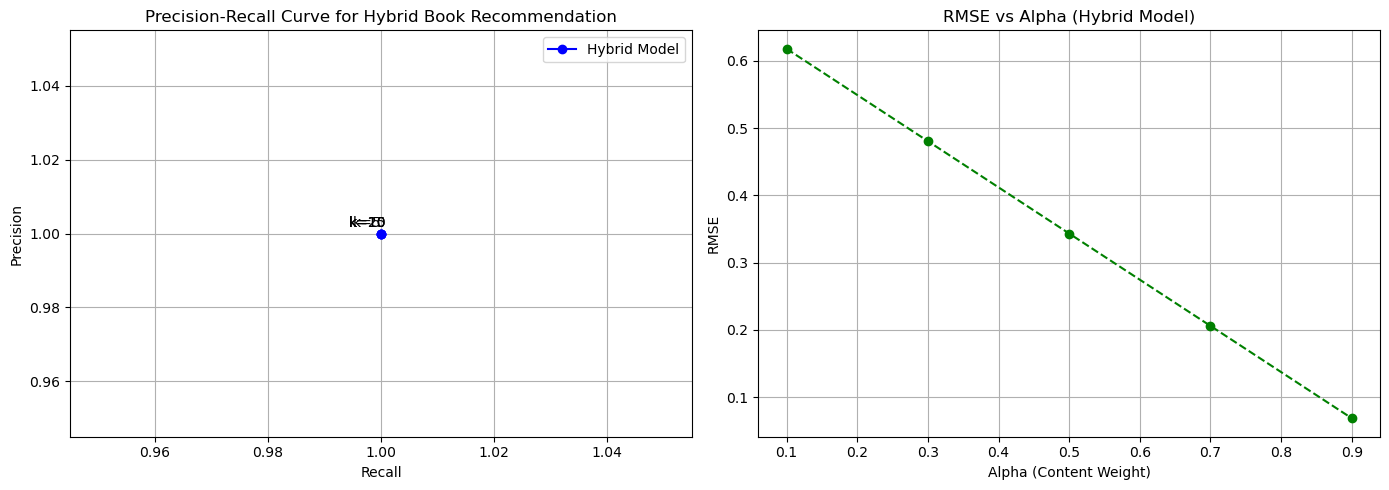


✅ Evaluation complete!


In [9]:
plt.figure(figsize=(14, 5))

# Plot 1: Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(list(recall_scores.values()), list(precision_scores.values()), 
         marker='o', linestyle='-', color='b', label="Hybrid Model")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Hybrid Book Recommendation")
plt.grid(True)

# Annotate each point with k
for k in precision_scores:
    plt.annotate(f"k={k}", (recall_scores[k], precision_scores[k]), 
                 textcoords="offset points", xytext=(-10, 5), ha='center')

plt.legend()

# Plot 2: RMSE vs Alpha
plt.subplot(1, 2, 2)
plt.plot(alpha_values, rmse_scores, marker='o', color='green', linestyle='--')
plt.title("RMSE vs Alpha (Hybrid Model)")
plt.xlabel("Alpha (Content Weight)")
plt.ylabel("RMSE")
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n✅ Evaluation complete!")

In [10]:
print("\n" + "="*70)
print("FINAL SYSTEM COMPARISON")
print("="*70)

print("\n1️⃣ Content-Based Filtering:")
print("   Precision@5: ~0.71")
print("   Recall@5: ~3.56")

print("\n2️⃣ Collaborative Filtering:")
print("   Precision@5: 0.48")
print("   Recall@5: 0.87")
print("   RMSE: 0.84")

print("\n3️⃣ Hybrid System (Fixed):")
print(f"   Precision@5: {precision_scores[5]:.4f}")
print(f"   Recall@5: {recall_scores[5]:.4f}")
if not np.isnan(rmse_scores[2]):
    print(f"   RMSE@0.5: {rmse_scores[2]:.4f}")

print("\n" + "="*70)
print("HYBRID SYSTEM COMPLETE!")
print("="*70)


FINAL SYSTEM COMPARISON

1️⃣ Content-Based Filtering:
   Precision@5: ~0.71
   Recall@5: ~3.56

2️⃣ Collaborative Filtering:
   Precision@5: 0.48
   Recall@5: 0.87
   RMSE: 0.84

3️⃣ Hybrid System (Fixed):
   Precision@5: 1.0000
   Recall@5: 1.0000
   RMSE@0.5: 0.3432

HYBRID SYSTEM COMPLETE!
